# Predicting restaurant visitors

Prompts: Predicting electric bill for domestic users in FL. KWH, $, zip code.

In [1]:
import pandas as pd
import numpy as np

# Load specific forecasting tools
from statsmodels.tsa.stattools import adfuller                  # stationarity test
from statsmodels.tsa.seasonal import seasonal_decompose         # ETS decomposition plots
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf    # determining (p,q) orders
from pmdarima import auto_arima                                 # determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX          # time series modelling
from statsmodels.tools.eval_measures import rmse                # metric


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
df = pd.read_csv('/Users/bala/Documents/Learning/RestaurantVisitors.csv',index_col='date',parse_dates=True)
#set the frequency
df.index.freq = 'D' 
#ordering to intuitively understand weekly seasonality
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = df['weekday'].astype('category', categories=cats, ordered=True)

In [3]:
#American holidays/ data set
df['holiday_name'].unique()

array(["New Year's Day", 'na', 'Martin Luther King Day', 'Groundhog Day',
       "Valentine's Day", 'Presidents Day', "St. Patrick's Day",
       'Good Friday', 'Easter', 'Easter Monday', 'Cinco de Mayo',
       "Mother's Day", 'Memorial Day', "Father's Day", 'Independence Day',
       'Labor Day', 'Columbus Day', 'Halloween', "Veterans' Day",
       'Thanksgiving', 'Black Friday', 'Christmas Eve', 'Christmas Day',
       "New Year's Eve"], dtype=object)

Prompt: Holidays. Historical weather data, by zip code. Exogenous variable - future values.

In [4]:
#rows from 2017-04-23 are 'future' dates
df.iloc[-50:-35,]

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-12,Wednesday,0,na,44.0,2.0,15.0,28.0,89.0
2017-04-13,Thursday,0,na,19.0,12.0,12.0,27.0,70.0
2017-04-14,Friday,1,Good Friday,41.0,74.0,57.0,49.0,221.0
2017-04-15,Saturday,0,na,69.0,24.0,66.0,59.0,218.0
2017-04-16,Sunday,1,Easter,58.0,35.0,60.0,100.0,253.0
2017-04-17,Monday,1,Easter Monday,63.0,21.0,24.0,32.0,140.0
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0


In [5]:
#holiday information provided for 'future' dates as well - needed to use it as an exog variables
df_train = df.loc[:'2017-04-22']
print(df_train[-2:])
df_test = df.loc['2017-04-23':]
print(df_test[0:])
print(df_test.shape)

             weekday  holiday holiday_name  rest1  rest2  rest3  rest4  total
date                                                                         
2017-04-21    Friday        0           na   38.0   53.0   36.0   38.0  165.0
2017-04-22  Saturday        0           na   97.0   20.0   50.0   59.0  226.0
              weekday  holiday   holiday_name  rest1  rest2  rest3  rest4  \
date                                                                        
2017-04-23     Sunday        0             na    NaN    NaN    NaN    NaN   
2017-04-24     Monday        0             na    NaN    NaN    NaN    NaN   
2017-04-25    Tuesday        0             na    NaN    NaN    NaN    NaN   
2017-04-26  Wednesday        0             na    NaN    NaN    NaN    NaN   
2017-04-27   Thursday        0             na    NaN    NaN    NaN    NaN   
2017-04-28     Friday        0             na    NaN    NaN    NaN    NaN   
2017-04-29   Saturday        0             na    NaN    NaN    NaN    Na

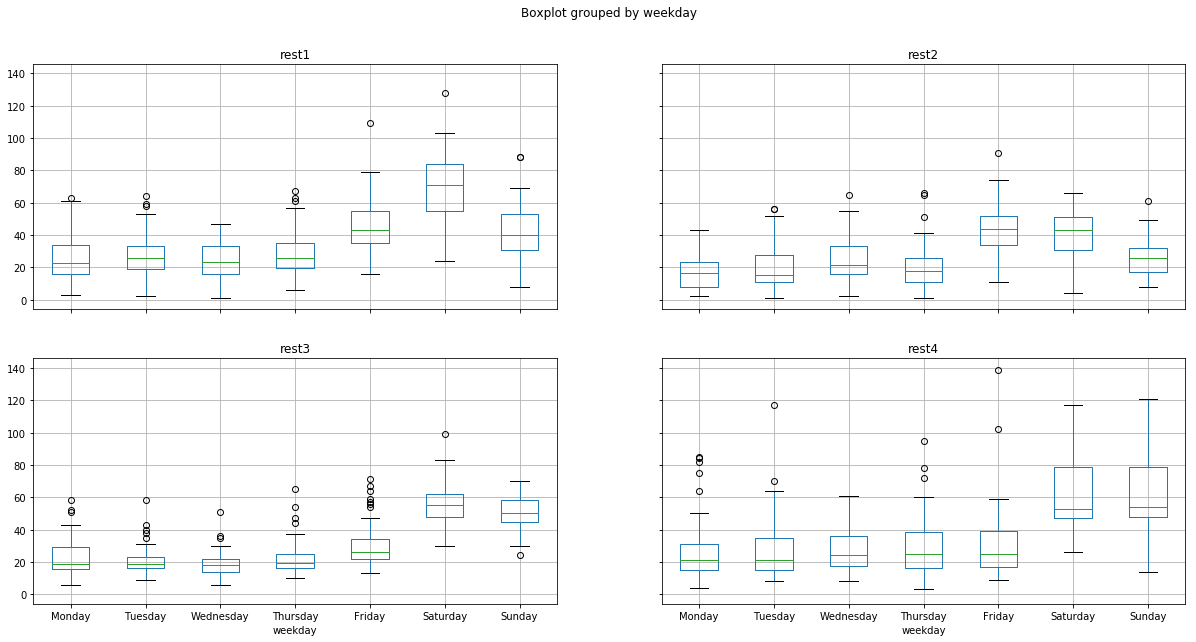

In [6]:
#individual restaurants showing weekly seasonality
df_train.boxplot(['rest1', 'rest2', 'rest3', 'rest4'],by='weekday', figsize=(20,10));

Prompt: Grouping by zip code

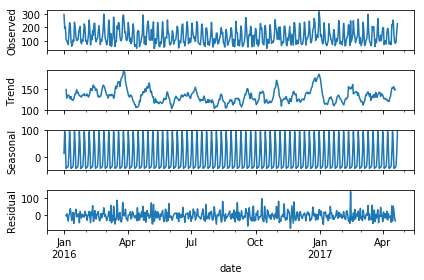

In [7]:
#validating this weekly seasonality using the total visitors across all 4 restaurants

#no trend but clear upswing towards the end of the year (holiday period) and around March (?)

result = seasonal_decompose(df_train['total'])
result.plot();

Prompt: Electric consumption - weekly & annual seasonality. FB Prophet.

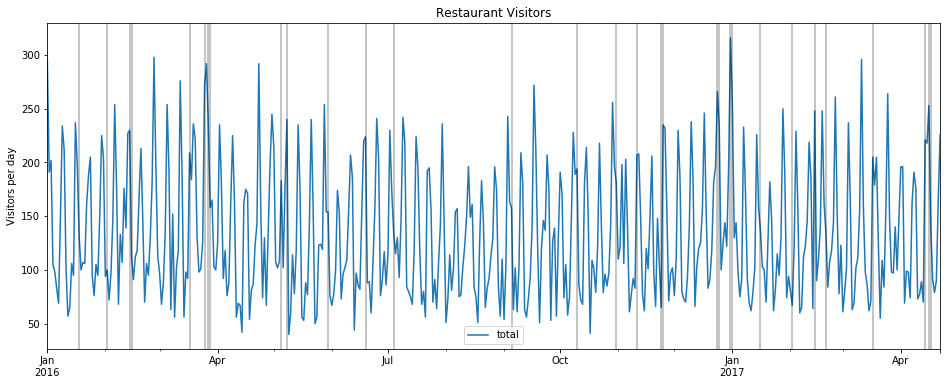

In [8]:
#Holidays have an impact, for example the year end period
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df_train['total'].plot(legend=True,figsize=(16,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df_train.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

# Manual determination of p,d,q and P,D,Q

In [9]:
#Stationarity/ need for differencing
adfuller(df_train['total'],autolag='AIC')

(-5.592496972543475,
 1.319377094694142e-06,
 18,
 459,
 {'1%': -3.4446773373329576,
  '5%': -2.8678574606780654,
  '10%': -2.5701349669405404},
 4596.809727672799)

## Differencing
'ADF test statistic','p-value','# lags used','# observations', 'critical values at 1, 5, and 10% significance
Null hypothesis - not stationary. Given low p-value, null hypothesis is rejected 
Suprising result, given the clear weekly seasonality. In any case, no differencing needed

<a href='https://otexts.com/fpp2/stationarity.html'> Hyndman Time Series Book</a>

## "AR Signature"

Ref: <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

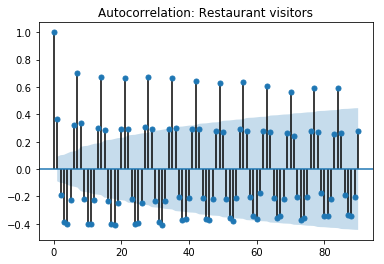

In [10]:
#Strong auto correlation 
title = 'Autocorrelation: Restaurant visitors'
lags = 90
plot_acf(df_train['total'],title=title,lags=lags);

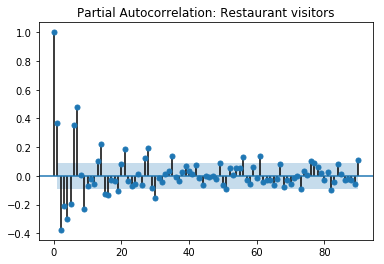

In [11]:
#much faster drop
title = 'Partial Autocorrelation: Restaurant visitors'
lags = 90
plot_pacf(df_train['total'],title=title,lags=lags);

# Finding p,d,q and P,D,Q using a standard module, <tt>pmdarima.auto_arima</tt> 

In [12]:
auto_arima(df_train['total'],seasonal=True,m=7, trace=True).summary()

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 7); AIC=4930.288, BIC=4963.644, Fit time=1.198 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=5269.484, BIC=5277.823, Fit time=0.024 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=4916.749, BIC=4933.428, Fit time=0.381 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=5049.644, BIC=5066.322, Fit time=0.236 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=5200.790, BIC=5213.298, Fit time=0.073 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=4845.442, BIC=4866.290, Fit time=0.893 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=4859.638, BIC=4876.316, Fit time=1.209 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=4847.043, BIC=4872.061, Fit time=1.327 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2417.721
Date:                           Wed, 18 Aug 2021   AIC                           4845.442
Time:                                   14:34:11   BIC                           4866.290
Sample:                                        0   HQIC                          4853.638
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.5659      4.363      4.714      0.000      12.015      29.117
ar.L1          0.1897      0.045      4.221      0.000       0.102       0.278
ar.S.L7        0.4258      0.037     11.606      0.000       0.354       0.498
ar.S.L14       0.3873      0.036     10.734      0.000       0.317       0.458
sigma2      1427.3968     86.679     16.468      0.000    1257.510    1597.284
===================================================================================
Ljung-Box (Q):                       77.20   Jarque-Bera (JB):                27.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.47
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fitting time series model

In [13]:
print(df_train.shape)
print(df_test.shape)

df_train_train = df_train.iloc[:-39]
df_val = df_train.iloc[-39:]

print(df_train_train.shape)
print(df_val.shape)

(478, 8)
(39, 8)
(439, 8)
(39, 8)


In [14]:
model = SARIMAX(df_train_train['total'],exog=df_train_train['holiday'],order=(1,0,0),
        seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  439
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2172.239
Date:                           Wed, 18 Aug 2021   AIC                           4354.479
Time:                                   14:34:13   BIC                           4374.901
Sample:                               01-01-2016   HQIC                          4362.536
                                    - 03-14-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       66.8952      4.222     15.846      0.000      58.621      75.169
ar.L1          0.2130      0.049      4.363      0.000       0.117       0.309
ar.S.L7        0.5148      0.042     12.375      0.000       0.433       0.596
ar.S.L14       0.4575      0.041     11.052      0.000       0.376       0.539
sigma2      1112.1607     72.559     15.328      0.000     969.947    1254.375
===================================================================================
Ljung-Box (Q):                      100.25   Jarque-Bera (JB):                 1.31
Prob(Q):                              0.00   Prob(JB):                         0.52
Heteroskedasticity (H):               0.90   Skew:                             0.11
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model assumptions and results interpretation  
1. Residuals are not correlated, i.e no signal remaining and only white noise (Ljung-Box)). Test fails but correlogram (ACF of residuals) shows small but statistically significant impact only 7 days out. So, acceptable shortcoming.   
2. Residuals have zero mean.  
3. Residuals do not have heteroskedasticity, i.e have constant variance. Again test fails. But Q-Q plot shows that the model is OK through most of its range and only fails at the extremes.  
4. Residuals are normally distributed (Jarque-Bera test comparing skew & kurtosis to that of a normal distribution). Test fails. But plots show the deviation is minor.

sigma2: Variance of the error term  

Sources: <a href='https://otexts.com/fpp2/residuals.html'>Hyndman</a>, <a href='https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/arima/interpret-the-results/key-results/?SID=117600'>Minitab</a>, <a href='https://www.statisticshowto.com/goldfeld-quandt-test/'>Goldfeld Quandt Test for homoskedasticity</a>, <a href='https://github.com/statsmodels/statsmodels/issues/2507#:%7E:text=The%20sigma2%20output%20in%20the,variance%20of%20the%20error%20term'>sigma2</a>


### Other metrics  

1. Maximum Likelihood Estimation (MLE): maximize L(y|X ; h), conditional probability of the output (y) given the input (X) given the modeling hypothesis (h). L is the likelihood function and h are the parameters beta0, beta1... betan. Log sums used in place of multiplication of small probabilities for each observation (We need the joint probability of all observations). Hence log likelihood function. Optimization is typically a minimization problem, so we minimize the negative log likelihood function which then measures the "cost" of the model.  
Source (Machine Learning Mastery): <a href='https://machinelearningmastery.com/what-is-maximum-likelihood-estimation-in-machine-learning/'>MLE</a>, <a href='https://machinelearningmastery.com/logistic-regression-with-maximum-likelihood-estimation/'>MLE for Machine Learning</a>  
  
2. Akaike Information Criterion (AIC): AIC = 2K - 2ln(L), where K is the number of independent variables used (+2) and L is the log-likelihood estimate. Used to compare models. Lower the AIC score, better the fit.   
Source: <a href='https://www.scribbr.com/statistics/akaike-information-criterion/'>AIC</a>
  
3. Bayesian Information Criterion (BIC): BIC = Kln(n) - 2ln(L). n is the number of observations. Similar to AIC, but different penalty for number of independent variables used.  
  
4. Hannan–Quinn Information Criterion (HQIC): HQIC = -2Lmax + 2Kln(ln(n)).  


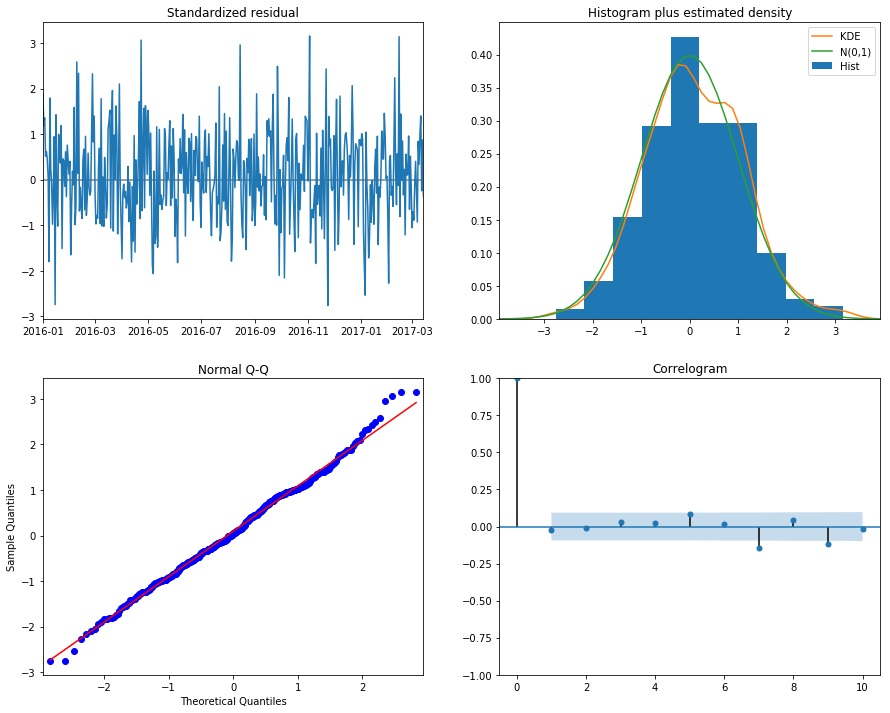

In [15]:
results.plot_diagnostics(figsize=(15, 12));

In [16]:
# Compare predictions to validation set
start=len(df_train_train)
end=len(df_train_train)+len(df_val)-1
exog_forecast = df_val[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

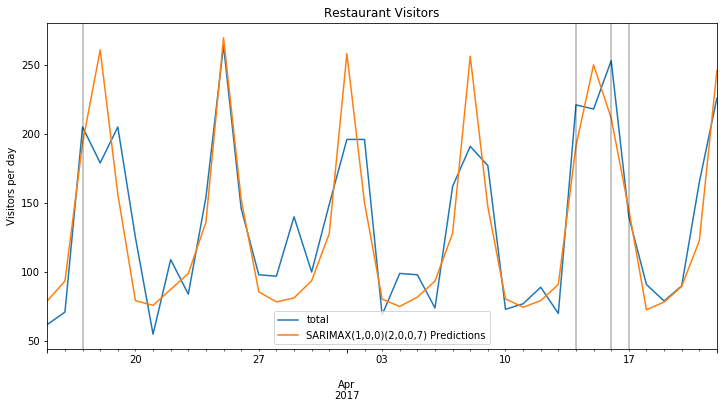

In [17]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df_val['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df_val.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [18]:
#comparing RMSE to mean and distribution of # of visitors
print('RMSE: ', rmse(df_val['total'], predictions))
df_val['total'].describe()

RMSE:  31.39970120493392


count     39.000000
mean     135.820513
std       59.419947
min       55.000000
25%       86.500000
50%      125.000000
75%      185.000000
max      264.000000
Name: total, dtype: float64

In [19]:
#to predict for the 'future', train with the all data available
model = SARIMAX(df_train['total'],exog=df_train['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df_train),len(df_train)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Forecast')

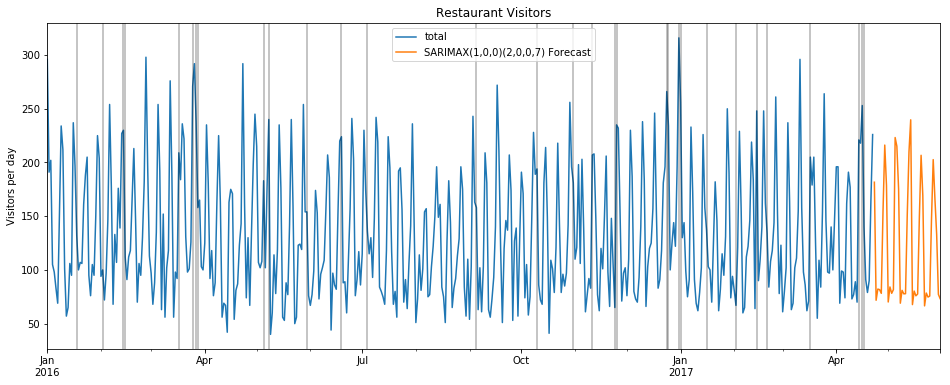

In [20]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df_train['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df_train.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);